# Dataset

In [8]:
from gym import spaces
import pandas as pd
import numpy as np
import random
import tqdm
import tensorflow as tf
import ray.rllib
import time
import gym, ray
import datetime

from ray.rllib.models import ModelCatalog
from ray.rllib.models.modelv2 import ModelV2
from ray.rllib.models.preprocessors import get_preprocessor
from ray.rllib.models.tf.recurrent_net import RecurrentNetwork
from ray.rllib.utils.annotations import override
from ray.rllib.utils.framework import try_import_tf, try_import_torch
from ray.tune.registry import register_env
import matplotlib.pyplot as plt

tf.random.set_seed(42)

In [9]:
df = pd.read_csv("dataset.csv")
df = df.iloc[:, 1:]

df['Time'] = pd.to_datetime(df['Time'])
df['Time'] = [(s-datetime.datetime(2015,5,1)).total_seconds() for s in df['Time']]
df['Time'] = df['Time']/1000

df_train = df[:87500]
df_val = df[87500:].reset_index().iloc[:, 1:]

df_train

,Time,RTS_High,RTS_Low,RTS_Close,RTS_Volume,SBRF_High,SBRF_Low,SBRF_Close,SBRF_Volume,NG_High,NG_Low,NG_Close,NG_Volume,BR_Open,BR_High,BR_Low,BR_Close,BR_Volume,SI_High,SI_Low,SI_Close,SI_Volume,GOLD_High,GOLD_Low,GOLD_Close,GOLD_Volume,GAZR_High,GAZR_Low,GAZR_Close,GAZR_Volume
0,39131.7,92730.0,92680.0,92680.0,639,13803.0,13799.0,13803.0,169.0,2.678,2.678,2.678,12.0,44.93,44.95,44.92,44.93,13850.0,66636.0,66612.0,66628.0,7726.0,1323.0,1322.4,1322.5,159.0,14263.0,14263.0,14263.0,3.0
1,39132.0,92700.0,92630.0,92650.0,1342,13802.0,13797.0,13799.0,168.0,2.684,2.682,2.682,4.0,44.94,44.95,44.88,44.88,15897.0,66678.0,66624.0,66659.0,7914.0,1322.6,1322.3,1322.6,11.0,14267.0,14261.0,14263.0,34.0
2,39132.3,92720.0,92620.0,92640.0,1295,13802.0,13797.0,13800.0,94.0,2.687,2.685,2.687,82.0,44.89,44.91,44.88,44.89,2953.0,66667.0,66603.0,66665.0,11283.0,1322.8,1322.0,1322.2,35.0,14260.0,14258.0,14259.0,8.0
3,39132.6,92640.0,92550.0,92620.0,1802,13804.0,13792.0,13804.0,235.0,2.687,2.685,2.685,12.0,44.89,44.92,44.86,44.92,1302.0,66712.0,66658.0,66674.0,7226.0,1322.3,1322.0,1322.3,51.0,14260.0,14260.0,14260.0,21.0
4,39132.9,92620.0,92550.0,92580.0,496,13803.0,13796.0,13800.0,485.0,2.686,2.685,2.685,2.0,44.91,44.92,44.87,44.91,5868.0,66704.0,66672.0,66683.0,2567.0,1322.7,1322.4,1322.6,40.0,14260.0,14258.0,14258.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87495,106506.9,108210.0,108050.0,108060.0,83,19079.0,19002.0,19062.0,396.0,2.767,2.765,2.767,114.0,77.73,77.74,77.52,77.66,29340.0,68722.0,68629.0,68707.0,3230.0,1208.1,1205.5,1205.5,506.0,15551.0,15528.0,15551.0,32.0
87496,106507.2,108150.0,108060.0,108120.0,54,19080.0,19036.0,19067.0,312.0,2.767,2.766,2.767,123.0,77.65,77.89,77.63,77.81,17908.0,68705.0,68650.0,68659.0,831.0,1206.3,1205.4,1206.1,100.0,15549.0,15540.0,15549.0,62.0
87497,106507.5,108180.0,108090.0,108100.0,44,19078.0,19047.0,19070.0,74.0,2.767,2.766,2.766,21.0,77.82,77.88,77.73,77.76,11505.0,68685.0,68633.0,68667.0,867.0,1206.5,1205.2,1206.3,78.0,15543.0,15540.0,15540.0,11.0
87498,106507.8,108140.0,108110.0,108120.0,11,19070.0,19048.0,19062.0,72.0,2.768,2.766,2.767,283.0,77.76,77.77,77.68,77.69,5360.0,68682.0,68634.0,68673.0,649.0,1206.0,1205.5,1205.5,61.0,15542.0,15542.0,15542.0,1.0


# Environment

In [10]:
INIT_BAL = 100_000
#for now we only support trades with 1 asset

class Leightweight(gym.Env):

  def __init__(self, df, tts):
    super(Leightweight, self).__init__()

    self.ticker_name = 'RTS'
    self.margin_needed = 12_500
    
    #self.multiplicator = 738
    self.multiplicator = 1.47
    #see https://www.moex.com/en/contract.aspx?code=RTS-12.21

    self.current_balance = INIT_BAL
    self.used_margin = 0 
    self.current_pos = 0
    self.prev_pos = 0

    self.time_alive = 0 
    self.df = df 
    self.tts = tts
    self.done = False
    self.current_ts = self.tts
    self.current_price = self.df.loc[self.current_ts, self.ticker_name + '_' + 'Close']
    self.fut_in_batch = 1
    self.pos_his = [0 for _ in range(self.tts)]

    self.actions_num = 5
    self.shift = (self.actions_num - 1) // 2
    self.action_space = spaces.Discrete(self.actions_num)

    self.observation_space = spaces.Dict({'rem_margin': spaces.Box(-10e6, 
                                                                    10e6, 
                                                                    shape = (1, ), 
                                                                    dtype = np.float32),
                                          'pos_history': spaces.Box(np.ones((self.tts,)) * np.array([-5]), 
                                                                    np.ones((self.tts,)) * np.array([5]), 
                                                                    shape = (self.tts, ), 
                                                                    dtype = np.int_),
                                          'dataframe': spaces.Box(- 10e3, 
                                                                  10e12, 
                                                                  shape = (self.tts, self.df.shape[1]), 
                                                                  dtype = np.float32)})
    
    

  def step(self, action):
    assert action in list(range(5))
    self.time_alive = self.time_alive + 1
    self.current_ts = self.current_ts + 1
    self.prev_price = self.current_price 
    self.prev_pos = self.current_pos
    self.current_price = self.df.loc[self.current_ts, self.ticker_name + '_' + 'Close']
    self.current_pos = action - self.shift
    self.pos_his = self.pos_his[1:] + [self.current_pos]
    change_in_pos = self.current_pos - self.prev_pos
    delta = self.current_pos * self.fut_in_batch * self.multiplicator * (self.current_price - self.prev_price) - 2 * np.abs(change_in_pos) * self.fut_in_batch
    self.current_balance += delta

    self.used_margin = np.abs(self.current_pos) * self.fut_in_batch * self.margin_needed

    if self.current_ts >= len(self.df) - self.tts -1:
      self.done = True

    penalty = 0 
    st = self.pos_his[-1]
    for i in range(self.tts-1):
      if self.pos_his[-2-i] == st:
        penalty +=1
      else:
        break

    self.reward = delta - 20*(penalty) - np.exp(8 * np.abs(np.mean(np.clip(self.pos_his, -1, 1))))

    next_obs_df = self.df[self.current_ts - self.tts + 1: self.current_ts + 1].to_numpy().astype(dtype = np.float32)

    rem_mar = np.reshape(np.array([self.current_balance - self.used_margin-5000]),
                                      newshape = (1,)).astype(dtype = np.float32)


    obs_cur_pos = np.reshape(np.array(self.pos_his),
                              newshape = (self.tts, )).astype(dtype = np.intc)


    if not self.observation_space['rem_margin'].contains(rem_mar):
        print("rem_margin>>", rem_mar, 'dn/c')
    if not self.observation_space['pos_history'].contains(obs_cur_pos):
        print("pos_history>>", obs_cur_pos, 'dn/c')
    if not self.observation_space['dataframe'].contains(next_obs_df):
        print("dataframe>>", dataframe, 'dn/c')

    self.obs = { "rem_margin"  : rem_mar,
                 "pos_history" : obs_cur_pos, 
                 "dataframe"   : next_obs_df} 

    self.reward *= 0.01

    return [self.obs, 
            self.reward, 
            self.done,
            {}]

  def reset(self):
      self.current_balance = INIT_BAL
      self.used_margin = 0
      self.current_pos = 0
      self.time_alive = 0 

      self.current_ts = random.randint(2 * self.tts, len(self.df) - 2 * self.tts)

      self.current_price = self.df.loc[self.current_ts, self.ticker_name + '_' + 'Close']

      next_obs_df = self.df[self.current_ts - self.tts + 1: self.current_ts + 1].to_numpy().astype(dtype = np.float32)

      rem_mar = np.reshape(np.array([self.current_balance - self.used_margin-5000]),
                            newshape = (1, )).astype(dtype = np.float32)


      obs_cur_pos = np.reshape(np.array(self.pos_his),
                                newshape = (self.tts, )).astype(dtype = np.intc)

      if not self.observation_space['rem_margin'].contains(rem_mar):
          print("rem_margin>>", rem_mar, 'dn/c')
      if not self.observation_space['pos_history'].contains(obs_cur_pos):
          print("pos_history>>", obs_cur_pos, 'dn/c')
      if not self.observation_space['dataframe'].contains(next_obs_df):
          print("dataframe>>", dataframe, 'dn/c')

      self.obs = { "rem_margin": rem_mar,
                   "pos_history" : obs_cur_pos, 
                   "dataframe" : next_obs_df} 

      return self.obs

  def render(self, mode = 'human', close = False):
      print(f'Step: {self.current_ts}')
      print(f'Balance: {self.current_balance}')



# Baseline: Buy and Hold

> 1 >> 100012.7 //
> 1001 >> 109891.1 //
> 2001 >> 115139.00000000001 //
> 3001 >> 106098.50000000007 //
> 4001 >> 106539.5000000001 //
> 5001 >> 101908.99999999994 //
> 6001 >> 111875.59999999985 //
> 7001 >> 107833.09999999987 //
res: 103717.09999999982


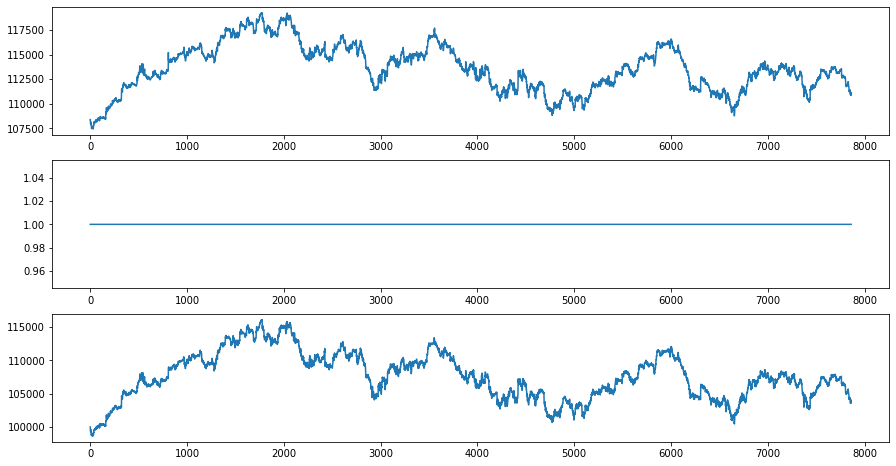

In [ ]:
last_bal = []
s = Leightweight(df = df_val, tts = 64)
state_ = s.step(3)
action = 3
post = []
bala = []
pr = []
for i in range(len(df_val) - 64*2 - 10):
    state_ = s.step(action)
    pr.append(state_[0]['dataframe'][-1][1])
    post.append(state_[0]['pos_history'][-1].reshape((1,))[0])
    bala.append(s.current_balance)
    if i % 1000 == 0:
        print(">",i+1, ">>", s.current_balance, '//')
print("res:", s.current_balance)
fig = plt.figure(figsize=(15,8))
#st = 1300
st = 0
p = 10_000
ax11 = fig.add_subplot(311)
ax11.plot(pr[st: st+p], label='BR1! Closing Price')
ax31 = fig.add_subplot(312)
ax31.plot(post[st: st+p], label='Position')
ax21 = fig.add_subplot(313)
ax21.plot(bala[st: st+p], label='Account Balance')

plt.savefig(f"LAST-buy_and_hold.png")

#Deep Reinforcement Learning

In [49]:
import os
from ray import tune
from ray.rllib.agents.dqn.distributional_q_tf_model import \
    DistributionalQTFModel
from ray.rllib.models import ModelCatalog
from ray.rllib.models.tf.misc import normc_initializer
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.models.tf.visionnet import VisionNetwork as MyVisionNetwork
from ray.rllib.policy.sample_batch import DEFAULT_POLICY_ID
from ray.rllib.utils.framework import try_import_tf
from ray.rllib.models.modelv2 import restore_original_dimensions

tf1, tf, tfv = try_import_tf()

class MyKerasModel(TFModelV2):
    """Custom model for policy gradient algorithms."""

    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name):
        super(MyKerasModel, self).__init__(obs_space, action_space,
                                           num_outputs, model_config, name)
        
        self.cell_size = 66

        tts = 64
        feat = 30
        
        self.dat = tf.keras.layers.Input(
            shape=[tts, feat], name="Dataframe")
        self.rem_mar = tf.keras.layers.Input(
            shape = [1], name = "Margin")
        self.cur_pos = tf.keras.layers.Input(
            shape = [tts], name = "Positions")
        
        cur_pos = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1))(self.cur_pos)
        
        lstm = tf.keras.layers.Concatenate()([cur_pos, self.dat])

        lstm = tf.keras.layers.LayerNormalization()(lstm)

        lstm = tf.keras.layers.LSTM(tts, return_sequences = False)(lstm)  


        conc = tf.keras.layers.Concatenate()([lstm, self.cur_pos])

        conc = tf.keras.layers.LayerNormalization()(conc)

        conc = tf.keras.layers.Dense(66,
                                     activation = tf.nn.relu,
                                     kernel_initializer=normc_initializer(0.01))(conc)
        conc = tf.keras.layers.LayerNormalization()(conc)
        
        conc = tf.keras.layers.Dense(33,
                                     activation = tf.nn.relu,
                                     kernel_initializer=normc_initializer(0.01))(conc)
        
        layer_1 = tf.keras.layers.Dense(
            16,
            activation=tf.nn.relu,
            kernel_initializer=normc_initializer(1.0))(conc)

        layer_1 = tf.keras.layers.LayerNormalization()(layer_1)
        
        layer_out = tf.keras.layers.Dense(
            num_outputs,
            name="Output",
            activation=None,
            kernel_initializer=normc_initializer(0.01))(layer_1)


        layer_2 = tf.keras.layers.Dense(
            16,
            activation=tf.nn.relu,
            kernel_initializer=normc_initializer(1.0))(conc)

        layer_2 = tf.keras.layers.LayerNormalization()(layer_2)

        value_out = tf.keras.layers.Dense(
            1,
            name="Value",
            activation=None,
            kernel_initializer=normc_initializer(0.01))(layer_2)
        self.base_model = tf.keras.Model([self.dat, self.rem_mar, self.cur_pos], [layer_out, value_out])
        #self.register_variables(self.base_model.variables)
        self.base_model.summary()

    def forward(self, input_dict, state, seq_lens):
        model_out, self._value_out = self.base_model([input_dict["obs"]["dataframe"], 
                                                      input_dict["obs"]["rem_margin"],
                                                      input_dict["obs"]["pos_history"]])
        return model_out, state

    def value_function(self):
        return tf.reshape(self._value_out, [-1])

In [ ]:
ray.shutdown()
ray.init()

ModelCatalog.register_custom_model(
    "keras_model", MyKerasModel)
train_env = "train_env"
register_env(train_env, lambda config: Leightweight(df_train, 64))

config = ray.rllib.agents.ppo.appo.DEFAULT_CONFIG.copy()
config['log_level'] = 'WARN'
config['num_gpus'] = 0
config['num_workers'] = 1
config['model']['custom_model'] = 'keras_model'
config['horizon'] = 2500
config['soft_horizon'] = False
config['lr'] = 0.0000001


agent = ray.rllib.agents.ppo.APPOTrainer(config, env=train_env)
agent.get_policy().config["explore"] = True

(RolloutWorker pid=2722) 2021-12-19 11:24:16.295183: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(RolloutWorker pid=2722) Model: "model"
(RolloutWorker pid=2722) __________________________________________________________________________________________________
(RolloutWorker pid=2722)  Layer (type)                   Output Shape         Param #     Connected to                     
(RolloutWorker pid=2722) ==================================================================================================
(RolloutWorker pid=2722)  Positions (InputLayer)         [(None, 64)]         0           []                               
(RolloutWorker pid=2722)                                                                                                   
(RolloutWorker pid=2722)  lambda (Lambda)                (None, 64, 1)        0           ['Positions[0][0]']              
(RolloutWorker pid=2722)                                                                                                   
(RolloutWorker pid=2722)  Dataframe (InputLayer)         [(None, 64, 30)]     0           []

(RolloutWorker pid=2722) 2021-12-19 11:24:17,438	WARNING deprecation.py:46 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!


(RolloutWorker pid=2722) Model: "model_1"
(RolloutWorker pid=2722) __________________________________________________________________________________________________
(RolloutWorker pid=2722)  Layer (type)                   Output Shape         Param #     Connected to                     
(RolloutWorker pid=2722) ==================================================================================================
(RolloutWorker pid=2722)  Positions (InputLayer)         [(None, 64)]         0           []                               
(RolloutWorker pid=2722)                                                                                                   
(RolloutWorker pid=2722)  lambda_1 (Lambda)              (None, 64, 1)        0           ['Positions[0][0]']              
(RolloutWorker pid=2722)                                                                                                   
(RolloutWorker pid=2722)  Dataframe (InputLayer)         [(None, 64, 30)]     0           

2021-12-19 11:24:27,155	INFO trainable.py:127 -- Trainable.setup took 20.390 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2021-12-19 11:24:27,157	WARNING util.py:57 -- Install gputil for GPU system monitoring.


# LSTM Training

 1 reward    nan/   nan/   nan len  nan
 2 reward    nan/   nan/   nan len  nan
 3 reward -328.17/-328.17/-328.17 len 2500.00
 4 reward -328.17/-252.80/-177.44 len 2500.00
 5 reward -328.17/-252.80/-177.44 len 2500.00
 6 reward -328.17/-245.36/-177.44 len 2500.00
 7 reward -328.17/-245.36/-177.44 len 2500.00
 8 reward -328.17/-212.04/-112.07 len 2500.00
 9 reward -328.17/-212.04/-112.07 len 2500.00
10 reward -340.69/-237.77/-112.07 len 2500.00
11 reward -340.69/-211.98/-83.03 len 2500.00
12 reward -340.69/-211.98/-83.03 len 2500.00


Exception in thread Thread-12:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.7/dist-packages/ray/rllib/execution/learner_thread.py", line 69, in run
    self.step()
  File "/usr/local/lib/python3.7/dist-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 143, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/usr/local/lib/python3.7/dist-packages/ray/rllib/execution/minibatch_buffer.py", line 43, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "/usr/lib/python3.7/queue.py", line 178, in get
    raise Empty
_queue.Empty



13 reward -384.97/-236.69/-83.03 len 2500.00
14 reward -384.97/-236.69/-83.03 len 2500.00
15 reward -384.97/-212.63/-44.17 len 2500.00
16 reward -384.97/-212.63/-44.17 len 2500.00
17 reward -384.97/-228.62/-44.17 len 2500.00
18 reward -384.97/-228.62/-44.17 len 2500.00
19 reward -384.97/-222.69/-44.17 len 2500.00
20 reward -384.97/-222.69/-44.17 len 2500.00
21 reward -384.97/-223.11/-44.17 len 2500.00
22 reward -384.97/-223.11/-44.17 len 2500.00
23 reward -384.97/-201.29/ 38.69 len 2500.00
24 reward -384.97/-205.63/ 38.69 len 2500.00
25 reward -384.97/-205.63/ 38.69 len 2500.00
Evaluation result: 
> 1 >> 100025.4 //
> 1001 >> 94807.59999999998 //
> 2001 >> 89999.09999999998 //
> 3001 >> 89197.10000000008 //
> 4001 >> 89540.30000000005 //
> 5001 >> 103136.70000000006 //
> 6001 >> 112621.1000000001 //
> 7001 >> 108721.80000000028 //
25 res: 105296.6000000003


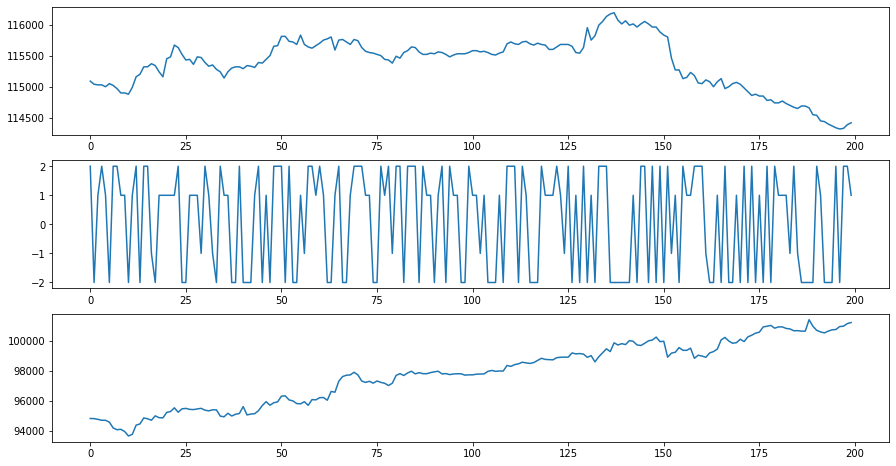

In [ ]:
status = "{:2d} reward {:6.2f}/{:6.2f}/{:6.2f} len {:4.2f}"
r = time.time()
for k in range(25):
    result = agent.train()
    print(status.format(
            k + 1,
            result["episode_reward_min"],
            result["episode_reward_mean"],
            result["episode_reward_max"],
            result["episode_len_mean"]
            ))
    chkpt_file = agent.save('Agent_checkpoints/')

agent.get_policy().config["explore"] = False 
last_bal = []
s = Leightweight(df = df_val, tts = 64)
state_ = s.step(2)
post = []
bala = []
pr = []
print("Evaluation result: ")
for i in range(len(df_val)- 2 * 64 - 1): 
    action = agent.compute_single_action(state_[0])
    last_action = action
    state_ = s.step(action)
    pr.append(state_[0]['dataframe'][-1][1])
    post.append(state_[0]['pos_history'][-1].reshape((1,))[0])
    bala.append(s.current_balance)
    if i % 1000 == 0:
        print(">",i+1, ">>", s.current_balance, '//')
print(k+1, "res:", s.current_balance)
fig = plt.figure(figsize=(15,8))
#st = 1300
st = 1000
p = 200
ax11 = fig.add_subplot(311)
ax11.plot(pr[st: st+p], label='RTS1! Closing Price')
ax21 = fig.add_subplot(313)
ax21.plot(bala[st: st+p], label='Account Balance')
ax31 = fig.add_subplot(312)
ax31.plot(post[st: st+p], label='Position')

plt.savefig(f"Part1_res.png")


# LSTM Evaluation

Plots the graph over **ALL** eval. period so indidiual positions(second graph can not be seen. Modify vriables $st$ and $p$ to change that. For instance, 1000 and 500 will work.

(RolloutWorker pid=6799) Model: "model"
(RolloutWorker pid=6799) __________________________________________________________________________________________________
(RolloutWorker pid=6799)  Layer (type)                   Output Shape         Param #     Connected to                     
(RolloutWorker pid=6799) ==================================================================================================
(RolloutWorker pid=6799)  Positions (InputLayer)         [(None, 64)]         0           []                               
(RolloutWorker pid=6799)                                                                                                   
(RolloutWorker pid=6799)  lambda (Lambda)                (None, 64, 1)        0           ['Positions[0][0]']              
(RolloutWorker pid=6799)                                                                                                   
(RolloutWorker pid=6799)  Dataframe (InputLayer)         [(None, 64, 30)]     0           []

(RolloutWorker pid=6799) 2021-12-19 14:13:57,797	WARNING deprecation.py:46 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!


(RolloutWorker pid=6799) [None]
(RolloutWorker pid=6799) [None]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Positions (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 lambda (Lambda)                (None, 64, 1)        0           ['Positions[0][0]']              
                                                                                                  
 Dataframe (InputLayer)         [(None, 64, 30)]     0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 31)       0           ['lambda[0][0]',                 
                              

2021-12-19 14:14:09,361	INFO trainable.py:127 -- Trainable.setup took 27.326 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2021-12-19 14:14:09,368	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2021-12-19 14:14:09,721	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: Agent_checkpoints/checkpoint_000025/checkpoint-25
2021-12-19 14:14:09,728	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 25, '_timesteps_total': 12500, '_time_total': 331.55027866363525, '_episodes_total': 13}


> 1 >> 100025.4 //
> 1001 >> 94807.59999999998 //
> 2001 >> 89999.09999999998 //
> 3001 >> 89197.10000000008 //
> 4001 >> 89540.30000000005 //
> 5001 >> 103136.70000000006 //
> 6001 >> 112621.1000000001 //
> 7001 >> 108721.80000000028 //
20 res: 105296.6000000003


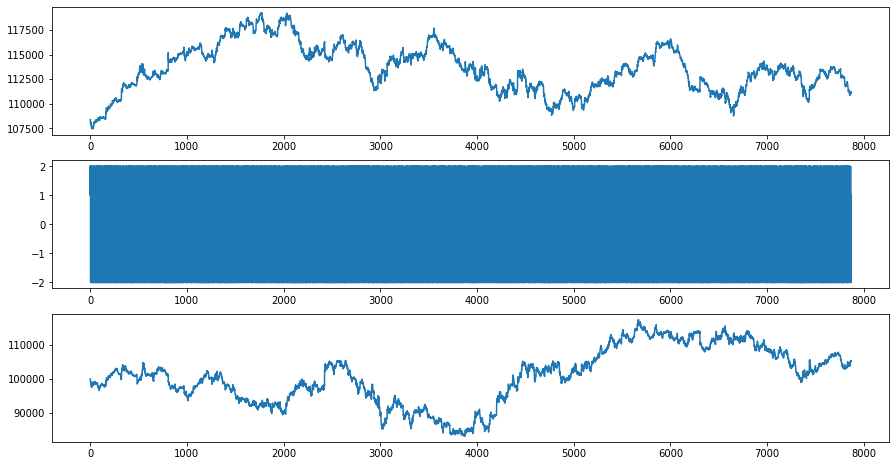

In [43]:
ray.shutdown()
ray.init()

ModelCatalog.register_custom_model(
    "keras_model", MyKerasModel)
train_env = "train_env"
register_env(train_env, lambda config: Leightweight(df_train, 64))

agent = ray.rllib.agents.ppo.APPOTrainer(config, env=train_env)
agent.restore('lstm_drl/checkpoint_000025/checkpoint-25')
agent.get_policy().config["explore"] = False

last_bal = []
s = Leightweight(df = df_val, tts = 64)
state_ = s.step(2)
post = []
bala = []
pr = []
for i in range(len(df_val)- 2 * 64 - 1): 
    action = agent.compute_single_action(state_[0])
    last_action = action
    state_ = s.step(action)
    pr.append(state_[0]['dataframe'][-1][1])
    post.append(state_[0]['pos_history'][-1].reshape((1,))[0])
    bala.append(s.current_balance)
    if i % 1000 == 0:
        print(">",i+1, ">>", s.current_balance, '//')
print(k+1, "res:", s.current_balance)
fig = plt.figure(figsize=(15,8))
#st = 1300
st = 0  
p = 10000
ax11 = fig.add_subplot(311)
ax11.plot(pr[st: st+p], label='RTS1! Closing Price')
ax21 = fig.add_subplot(313)
ax21.plot(bala[st: st+p], label='Account Balance')
ax31 = fig.add_subplot(312)
ax31.plot(post[st: st+p], label='Position')

plt.savefig(f"Part1eval_res.png")

# Conv1D Architecture

In [45]:
import os
from ray import tune
from ray.rllib.agents.dqn.distributional_q_tf_model import \
    DistributionalQTFModel
from ray.rllib.models import ModelCatalog
from ray.rllib.models.tf.misc import normc_initializer
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.models.tf.visionnet import VisionNetwork as MyVisionNetwork
from ray.rllib.policy.sample_batch import DEFAULT_POLICY_ID
from ray.rllib.utils.framework import try_import_tf
from ray.rllib.models.modelv2 import restore_original_dimensions

tf1, tf, tfv = try_import_tf()

class MyKerasModel(TFModelV2):
    """Custom model for policy gradient algorithms."""

    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name):
        super(MyKerasModel, self).__init__(obs_space, action_space,
                                           num_outputs, model_config, name)
        
        self.cell_size = 66

        tts = 64
        feat = 30
        
        self.dat = tf.keras.layers.Input(
            shape=[tts, feat], name="Dataframe")
        self.rem_mar = tf.keras.layers.Input(
            shape = [1], name = "Margin")
        self.cur_pos = tf.keras.layers.Input(
            shape = [tts], name = "Positions")
        
        cur_pos = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1))(self.cur_pos)
        
        lstm = tf.keras.layers.Concatenate()([cur_pos, self.dat])

        lstm = tf.keras.layers.LayerNormalization()(lstm)

        lstm = tf.keras.layers.Conv1D(self.cell_size, kernel_size = 51, strides = 7)(lstm)

        lstm = tf.keras.layers.Flatten()(lstm)


        conc = tf.keras.layers.Concatenate()([lstm, self.cur_pos])

        conc = tf.keras.layers.LayerNormalization()(conc)

        conc = tf.keras.layers.Dense(128,
                                     activation = tf.nn.relu,
                                     kernel_initializer=normc_initializer(0.01))(conc)
        conc = tf.keras.layers.LayerNormalization()(conc)
        
        conc = tf.keras.layers.Dense(64,
                                     activation = tf.nn.relu,
                                     kernel_initializer=normc_initializer(0.01))(conc)
        
        layer_1 = tf.keras.layers.Dense(
            32,
            activation=tf.nn.relu,
            kernel_initializer=normc_initializer(1.0))(conc)

        layer_1 = tf.keras.layers.LayerNormalization()(layer_1)
        
        layer_out = tf.keras.layers.Dense(
            num_outputs,
            name="Output",
            activation=None,
            kernel_initializer=normc_initializer(0.01))(layer_1)


        layer_2 = tf.keras.layers.Dense(
            32,
            activation=tf.nn.relu,
            kernel_initializer=normc_initializer(1.0))(conc)

        layer_2 = tf.keras.layers.LayerNormalization()(layer_2)

        value_out = tf.keras.layers.Dense(
            1,
            name="Value",
            activation=None,
            kernel_initializer=normc_initializer(0.01))(layer_2)
        self.base_model = tf.keras.Model([self.dat, self.rem_mar, self.cur_pos], [layer_out, value_out])
        #self.register_variables(self.base_model.variables)
        self.base_model.summary()

    def forward(self, input_dict, state, seq_lens):
        model_out, self._value_out = self.base_model([input_dict["obs"]["dataframe"], 
                                                      input_dict["obs"]["rem_margin"],
                                                      input_dict["obs"]["pos_history"]])
        return model_out, state

    def value_function(self):
        return tf.reshape(self._value_out, [-1])

In [38]:
ray.shutdown()
ray.init()

ModelCatalog.register_custom_model(
    "keras_model", MyKerasModel)
train_env = "train_env"
register_env(train_env, lambda config: Leightweight(df_train, 64))

config = ray.rllib.agents.ppo.appo.DEFAULT_CONFIG.copy()
config['log_level'] = 'WARN'
config['num_gpus'] = 0
config['num_workers'] = 1
config['model']['custom_model'] = 'keras_model'
config['horizon'] = 2000
config['soft_horizon'] = False
config['lr'] = 0.00000001
config['train_batch_size'] = 250
config['entropy_coeff'] = 0.05

agent = ray.rllib.agents.ppo.APPOTrainer(config, env=train_env)
agent.get_policy().config["explore"] = True

(RolloutWorker pid=6267) Model: "model"
(RolloutWorker pid=6267) __________________________________________________________________________________________________
(RolloutWorker pid=6267)  Layer (type)                   Output Shape         Param #     Connected to                     
(RolloutWorker pid=6267) ==================================================================================================
(RolloutWorker pid=6267)  Positions (InputLayer)         [(None, 64)]         0           []                               
(RolloutWorker pid=6267)                                                                                                   
(RolloutWorker pid=6267)  lambda (Lambda)                (None, 64, 1)        0           ['Positions[0][0]']              
(RolloutWorker pid=6267)                                                                                                   
(RolloutWorker pid=6267)  Dataframe (InputLayer)         [(None, 64, 30)]     0           []

(RolloutWorker pid=6267) 2021-12-19 12:45:32,788	WARNING deprecation.py:46 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!


(RolloutWorker pid=6267) [None]
(RolloutWorker pid=6267) [None]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Positions (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 lambda (Lambda)                (None, 64, 1)        0           ['Positions[0][0]']              
                                                                                                  
 Dataframe (InputLayer)         [(None, 64, 30)]     0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 31)       0           ['lambda[0][0]',                 
                              

2021-12-19 12:45:40,397	INFO trainable.py:127 -- Trainable.setup took 15.436 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2021-12-19 12:45:40,400	WARNING util.py:57 -- Install gputil for GPU system monitoring.


# Conv1D Training

 1 reward    nan/   nan/   nan len  nan
 2 reward -270.24/-270.24/-270.24 len 2000.00
 3 reward -270.24/-188.81/-107.38 len 2000.00
 4 reward -423.52/-267.05/-107.38 len 2000.00
 5 reward -423.52/-266.81/-107.38 len 2000.00
 6 reward -423.52/-245.75/-107.38 len 2000.00


Exception in thread Thread-242:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.7/dist-packages/ray/rllib/execution/learner_thread.py", line 69, in run
    self.step()
  File "/usr/local/lib/python3.7/dist-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 143, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/usr/local/lib/python3.7/dist-packages/ray/rllib/execution/minibatch_buffer.py", line 43, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "/usr/lib/python3.7/queue.py", line 178, in get
    raise Empty
_queue.Empty



 7 reward -423.52/-249.79/-107.38 len 2000.00
 8 reward -423.52/-250.91/-107.38 len 2000.00
 9 reward -423.52/-264.55/-107.38 len 2000.00
10 reward -423.52/-257.55/-107.38 len 2000.00
11 reward -457.06/-277.50/-107.38 len 2000.00
12 reward -457.06/-257.90/-61.94 len 2000.00
13 reward -457.06/-257.62/-61.94 len 2000.00
14 reward -457.06/-266.91/-61.94 len 2000.00
15 reward -457.06/-268.12/-61.94 len 2000.00
16 reward -457.06/-267.04/-61.94 len 2000.00
17 reward -457.06/-261.85/-61.94 len 2000.00
18 reward -457.06/-256.40/-61.94 len 2000.00
19 reward -457.06/-246.12/-61.94 len 2000.00
20 reward -457.06/-238.67/-61.94 len 2000.00
Evaluation result: 
> 1 >> 100012.7 //
> 1001 >> 111364.20000000007 //
> 2001 >> 110560.39999999997 //
> 3001 >> 103732.1 //
> 4001 >> 94119.49999999991 //
> 5001 >> 89610.59999999969 //
> 6001 >> 87129.3999999997 //
> 7001 >> 77726.09999999958 //
20 res: 80483.09999999951


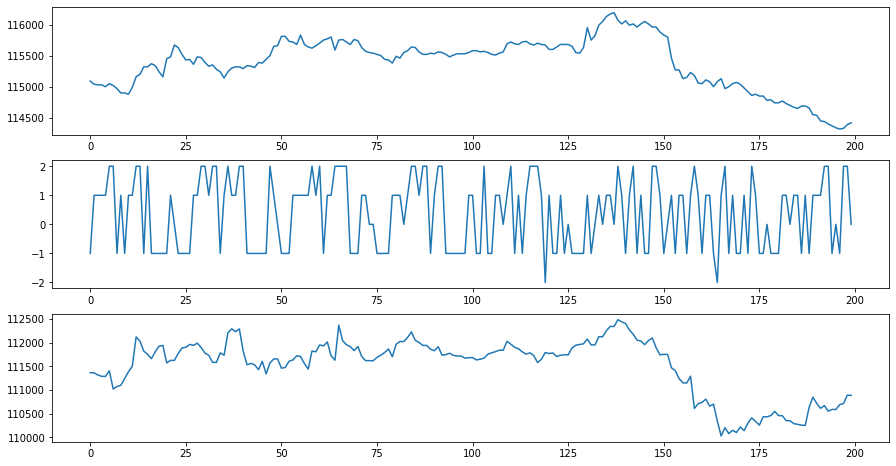

In [39]:
status = "{:2d} reward {:6.2f}/{:6.2f}/{:6.2f} len {:4.2f}"
r = time.time()
for k in range(20):
    result = agent.train()
    print(status.format(
            k + 1,
            result["episode_reward_min"],
            result["episode_reward_mean"],
            result["episode_reward_max"],
            result["episode_len_mean"]
            ))
    chkpt_file = agent.save('Agent_checkpoints_conv/')

agent.get_policy().config["explore"] = False 
last_bal = []
s = Leightweight(df = df_val, tts = 64)
state_ = s.step(2)
post = []
bala = []
pr = []
print("Evaluation result: ")
for i in range(len(df_val)- 2 * 64 - 1): 
    action = agent.compute_single_action(state_[0])
    last_action = action
    state_ = s.step(action)
    pr.append(state_[0]['dataframe'][-1][1])
    post.append(state_[0]['pos_history'][-1].reshape((1,))[0])
    bala.append(s.current_balance)
    if i % 1000 == 0:
        print(">",i+1, ">>", s.current_balance, '//')
print(k+1, "res:", s.current_balance)
fig = plt.figure(figsize=(15,8))
#st = 1300
st = 1000
p = 200
ax11 = fig.add_subplot(311)
ax11.plot(pr[st: st+p], label='RTS1! Closing Price')
ax21 = fig.add_subplot(313)
ax21.plot(bala[st: st+p], label='Account Balance')
ax31 = fig.add_subplot(312)
ax31.plot(post[st: st+p], label='Position')

plt.savefig(f"Part1convm_res.png")


# Conv1D Evaluation

Too see what exactly the agent does, in this model we plotted a part of the validation set.

(RolloutWorker pid=7743) Model: "model"
(RolloutWorker pid=7743) __________________________________________________________________________________________________
(RolloutWorker pid=7743)  Layer (type)                   Output Shape         Param #     Connected to                     
(RolloutWorker pid=7743) ==================================================================================================
(RolloutWorker pid=7743)  Positions (InputLayer)         [(None, 64)]         0           []                               
(RolloutWorker pid=7743)                                                                                                   
(RolloutWorker pid=7743)  lambda (Lambda)                (None, 64, 1)        0           ['Positions[0][0]']              
(RolloutWorker pid=7743)                                                                                                   
(RolloutWorker pid=7743)  Dataframe (InputLayer)         [(None, 64, 30)]     0           []

(RolloutWorker pid=7743) 2021-12-19 14:25:50,864	WARNING deprecation.py:46 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!


(RolloutWorker pid=7743) Model: "model_1"
(RolloutWorker pid=7743) __________________________________________________________________________________________________
(RolloutWorker pid=7743)  Layer (type)                   Output Shape         Param #     Connected to                     
(RolloutWorker pid=7743) ==================================================================================================
(RolloutWorker pid=7743)  Positions (InputLayer)         [(None, 64)]         0           []                               
(RolloutWorker pid=7743)                                                                                                   
(RolloutWorker pid=7743)  lambda_1 (Lambda)              (None, 64, 1)        0           ['Positions[0][0]']              
(RolloutWorker pid=7743)                                                                                                   
(RolloutWorker pid=7743)  Dataframe (InputLayer)         [(None, 64, 30)]     0           

2021-12-19 14:25:58,713	INFO trainable.py:127 -- Trainable.setup took 17.477 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2021-12-19 14:25:58,719	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2021-12-19 14:25:59,001	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: Agent_checkpoints_conv/checkpoint_000025/checkpoint-25
2021-12-19 14:25:59,005	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 25, '_timesteps_total': 12500, '_time_total': 270.9863541126251, '_episodes_total': 27}


> 1 >> 99966.6 //
> 1001 >> 85249.69999999995 //
> 2001 >> 74753.8999999999 //
> 3001 >> 92834.90000000013 //


Exception in thread Thread-337:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.7/dist-packages/ray/rllib/execution/learner_thread.py", line 69, in run
    self.step()
  File "/usr/local/lib/python3.7/dist-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 143, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/usr/local/lib/python3.7/dist-packages/ray/rllib/execution/minibatch_buffer.py", line 43, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "/usr/lib/python3.7/queue.py", line 178, in get
    raise Empty
_queue.Empty



> 4001 >> 91952.9000000002 //
> 5001 >> 101213.9000000003 //
> 6001 >> 81280.70000000055 //
> 7001 >> 89365.7000000003 //
20 res: 97068.50000000035


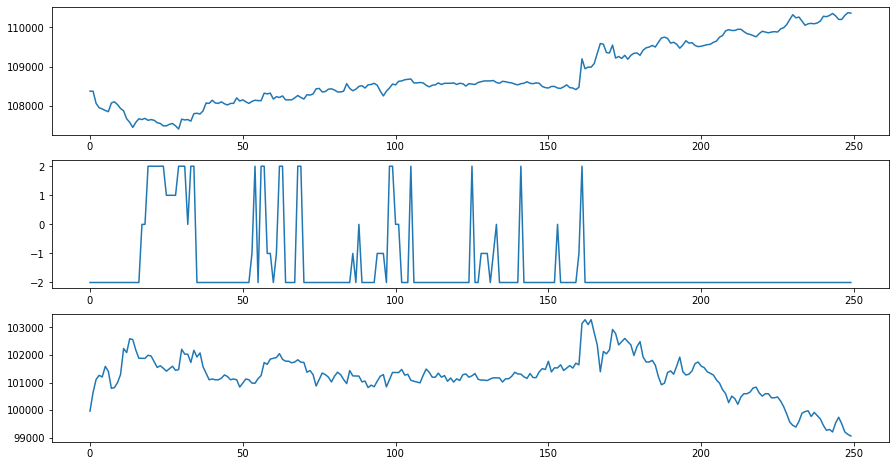

In [48]:
ray.shutdown()
ray.init()

ModelCatalog.register_custom_model(
    "keras_model", MyKerasModel)
train_env = "train_env"
register_env(train_env, lambda config: Leightweight(df_train, 64))

agent = ray.rllib.agents.ppo.APPOTrainer(config, env=train_env)
agent.restore('Conv1d_drl/checkpoint_000025/checkpoint-25')
agent.get_policy().config["explore"] = False

last_bal = []
s = Leightweight(df = df_val, tts = 64)
state_ = s.step(2)
post = []
bala = []
pr = []
for i in range(len(df_val)- 2 * 64 - 1): 
    action = agent.compute_single_action(state_[0])
    last_action = action
    state_ = s.step(action)
    pr.append(state_[0]['dataframe'][-1][1])
    post.append(state_[0]['pos_history'][-1].reshape((1,))[0])
    bala.append(s.current_balance)
    if i % 1000 == 0:
        print(">",i+1, ">>", s.current_balance, '//')
print(k+1, "res:", s.current_balance)
fig = plt.figure(figsize=(15,8))
#st = 1300
st = 0
p = 250
ax11 = fig.add_subplot(311)
ax11.plot(pr[st: st+p], label='RTS1! Closing Price')
ax21 = fig.add_subplot(313)
ax21.plot(bala[st: st+p], label='Account Balance')
ax31 = fig.add_subplot(312)
ax31.plot(post[st: st+p], label='Position')

plt.savefig(f"Part1eval_res_conv.png")